# Science adaptation data analysis

Basic statistics on science adaptation dataset. Results shown below are for initial v0.1 release.

## Get stats

Read in all datasets, get summary stats, and dump to file.

In [1]:
# Get dataset stats. Run this once and cache it.

import datasets

from tasks.task import TaskCollection
from copy import deepcopy
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path
import pandas as pd


def get_stats(task):
    "Get stats for a single task."
    metadata = deepcopy(task.metadata)
    res = {"name": task.name}
    metadata["domains"] = " | ".join(metadata["domains"])
    del metadata["contributor"]
    res.update(metadata)
    ds = datasets.load_dataset("allenai/science_adapt_dev", task.name)
    counts = {"n_train": ds["train"].num_rows,
              "n_validation": ds["validation"].num_rows,
              "n_test": ds["test"].num_rows}

    # Just look at train token counts
    toks_input = ds["train"]["_input_toks"]
    toks_output = ds["train"]["_output_toks"]

    counts["total_toks_input"] = int(pd.Series(toks_input).sum())
    counts["total_toks_output"] = int(pd.Series(toks_output).sum())
    counts["total_toks"] = counts["total_toks_input"] + counts["total_toks_output"]
    counts["median_toks_input"] = int(pd.Series(toks_input).median())
    counts["median_toks_output"] = int(pd.Series(toks_output).median())
    res.update(counts)

    return res


# Make stats file, or load if already done.
stats_file = Path("results/stats.tsv")
if stats_file.exists():
    df = pd.read_table(stats_file)
else:
    tc = TaskCollection()
    workers = 20
    stats_file.parent.mkdir(exist_ok=True)
    with ProcessPoolExecutor(max_workers=workers) as executor:
        res = list(executor.map(get_stats, tc.tasks.values()))
        df = pd.DataFrame(res).set_index("name").sort_index()
        df.to_csv(stats_file, sep="\t")


In [2]:
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})

def make_pie_charts(df, field):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.ravel()
    task_counts = df[field].value_counts().sort_index()
    task_counts.plot.pie(ax=axs[0], autopct=lambda p: '{:.0f}'.format(p * sum(task_counts) / 100))
    axs[0].set_title("Number of tasks")

    inst_counts = df.groupby(field)["n_train"].sum().sort_index()
    inst_counts.plot.pie(ax=axs[1], autopct=lambda p: '{:.0f}'.format(p * sum(inst_counts) / 100))
    axs[1].set_title("Number of train instances")

    tok_counts = df.groupby(field)["total_toks"].sum().sort_index()
    print("Token counts:")
    print(tok_counts)
    # The total token counts can be really unbalanced; truncate the largest one so it's
    # the size of the rest combined.
    # Calculate the sum of all values except the largest one
    sum_except_max = tok_counts.sum() - tok_counts.max()
    # Replace the largest value with this sum
    tok_counts.loc[tok_counts.idxmax()] = sum_except_max
    tok_counts.plot.pie(ax=axs[2], autopct=lambda p: '{:.2e}'.format(p * sum(tok_counts) / 100))
    axs[2].set_title("Number of train tokens (input + output).")

    axs[3].axis("off")

    fig.suptitle(field)
    fig.tight_layout()

## Aggregate statistics

Total number of instances and tokens below.

In [3]:
df[
    [
        "n_train",
        "n_validation",
        "n_test",
        "total_toks_input",
        "total_toks_output",
        "total_toks",
    ]
].sum().apply(lambda x: f"{x:,}")

n_train                  168,109
n_validation              54,855
n_test                    68,629
total_toks_input     654,698,215
total_toks_output     32,415,744
total_toks           687,113,959
dtype: object

## Task type statistics

Number of tasks per task type, and number of train instances per task type. There are lot of summarization instances because it's easy to get weakly-supervised data (e.g. use abstracts as summaries of papers, papers summaries on OpenReview, etc).

NOTE: token counts are very imbalanced (summarization has much more tokens than every other task), so in the plot I truncate the largest token count to be the sum of the token counts for the remaining gruops for easy of visualization.

Token counts:
major_category
classification     10425001
entailment          5108251
ie                 21532515
qa                 41260837
summarization     608787355
Name: total_toks, dtype: int64


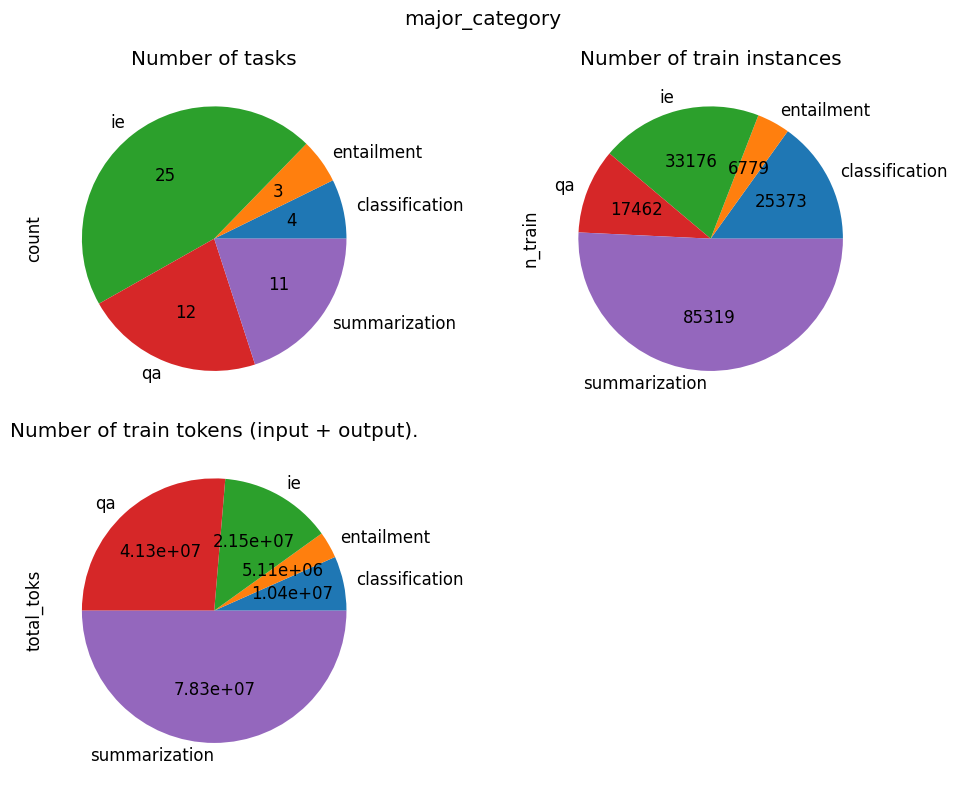

In [4]:
from matplotlib import pyplot as plt

df["major_category"] = [x.split(".")[0] for x in df["task"]]
make_pie_charts(df, "major_category")


## Domain statistics

Note that some tasks can be associated with multiple domains, so there's some double-counting here. It's fairly heavy on biomed, but there's a good amount of AI instances as well.

Based on this, maybe we should combine chemistry and materials science?

Token counts:
domain
artificial_intelligence    187448159
biomedicine                289631127
chemistry                   94227824
clinical_medicine          150947673
materials_science           13420799
misc                       114142838
Name: total_toks, dtype: int64


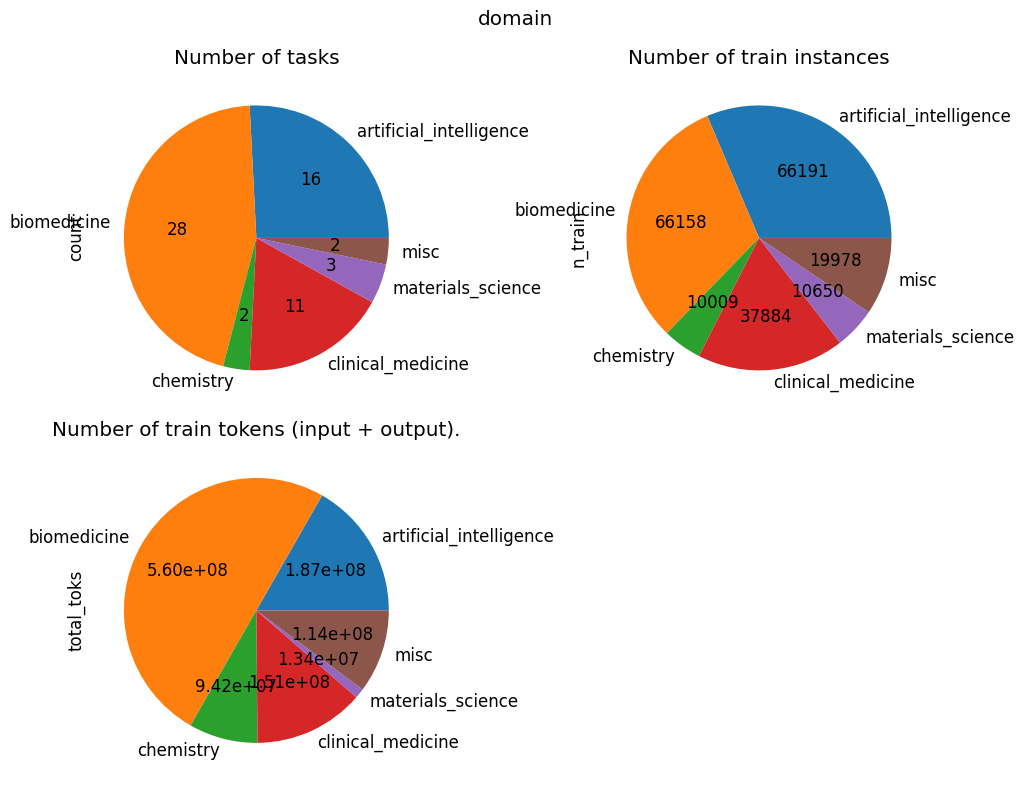

In [5]:
domain_df = []

for _, row in df.iterrows():
    domains = row["domains"].split(" | ")
    for domain in domains:
        domain_df.append({"domain": domain, "n_train": row["n_train"], "total_toks": row["total_toks"]})

domain_df = pd.DataFrame(domain_df)

make_pie_charts(domain_df, "domain")


## Input and output context

The types of input and output expected by the model. Interestingly, the majority of the tasks require `json` output. This happens for both IE tasks, as well as tasks like QA and entailment that require some kind of rationale justifying their answer.

Token counts:
input_context
multiple_paragraphs    537564108
paragraph              147302538
sentence                 1247642
structured                999671
Name: total_toks, dtype: int64


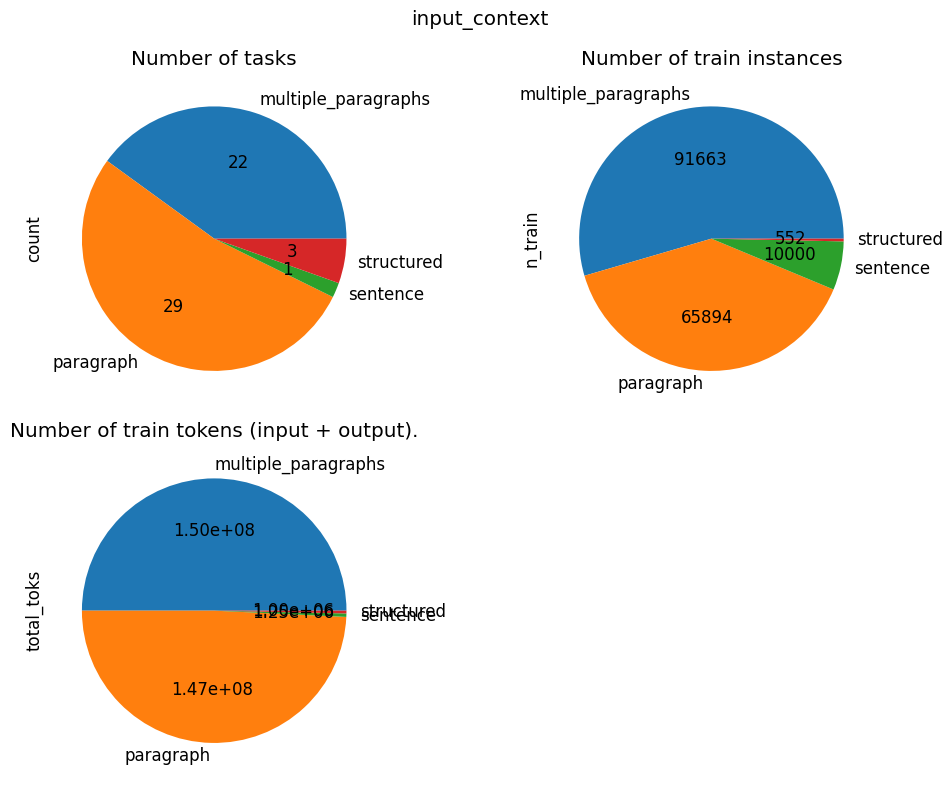

In [6]:
make_pie_charts(df, "input_context")


Token counts:
output_context
json          41982391
jsonlines       999671
label         28424440
paragraph    606133368
sentence       9574089
Name: total_toks, dtype: int64


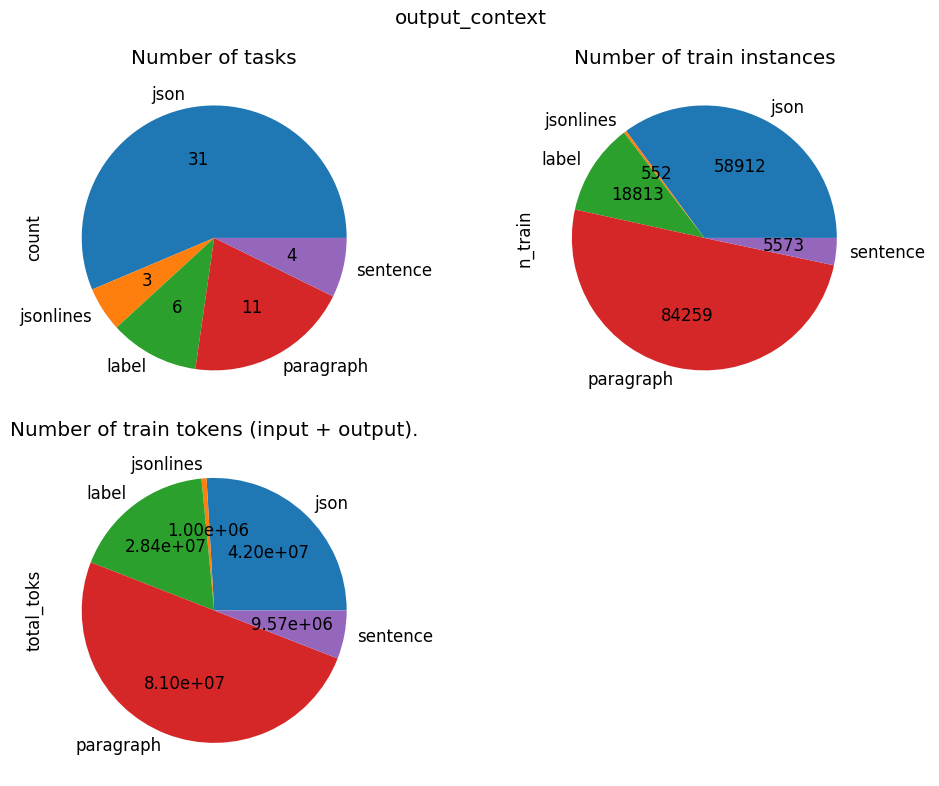

In [7]:
make_pie_charts(df, "output_context")


## Distribution of instances per task

Histograms showing the number of instances per task, across folds. The long tail at 10k is mostly summarization tasks for which we have essentially unlimited data.

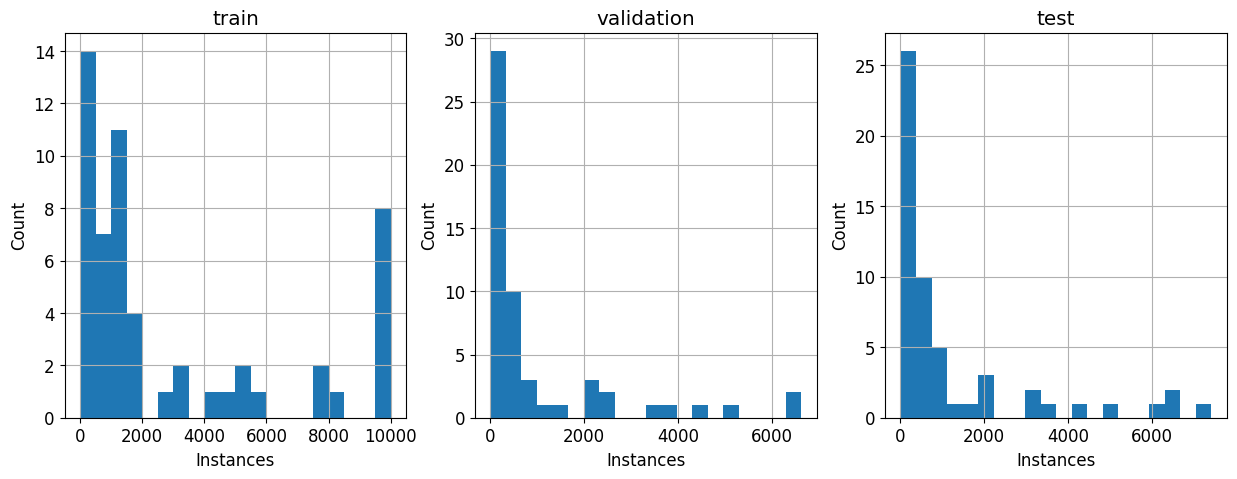

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for split, ax in zip(["train", "validation", "test"], axs):
    df[f"n_{split}"].hist(ax=ax, bins=20)
    ax.set_xlabel("Instances")
    ax.set_ylabel("Count")
    ax.set_title(split)


## Instance length distribution

Distribution of median input and output length, in tokens (using llama-2 tokenizer).

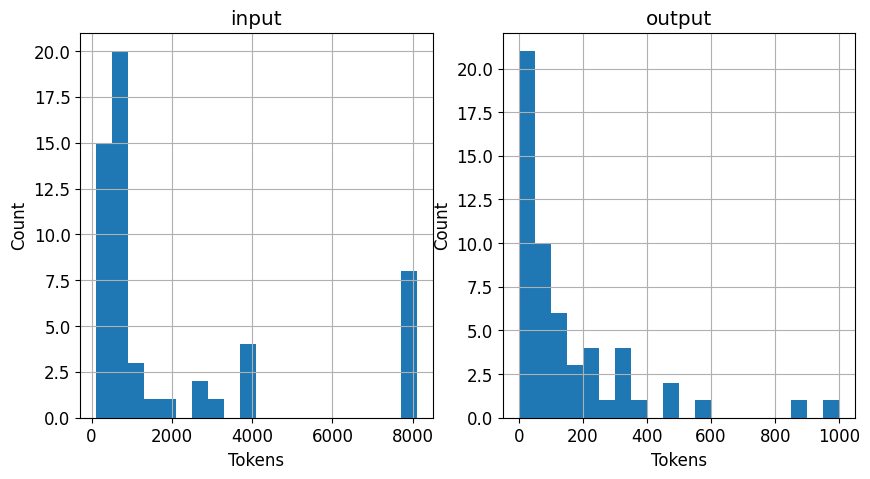

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for name, ax in zip(["input", "output"], axs):
    # Clip very long tasks.
    upper = 8096 if name == "input" else 1000
    df[f"median_toks_{name}"].clip(upper=upper).hist(ax=ax, bins=20)
    ax.set_xlabel("Tokens")
    ax.set_ylabel("Count")
    ax.set_title(name)


## Full list of tasks

In [16]:
fields_to_show = ["name", "domains", "task", "source_type", "input_context", "output_context", "n_train"]
df[fields_to_show].sort_values(["domains", "task"])

,name,domains,task,source_type,input_context,output_context,n_train
0,acl_arc_intent_classification,artificial_intelligence,classification,single_source,multiple_paragraphs,label,1688
34,multicite_intent_classification,artificial_intelligence,classification,single_source,paragraph,json,5491
45,scicite_classification,artificial_intelligence,classification,single_source,paragraph,label,8194
50,scierc_ner,artificial_intelligence,ie.named_entity_recognition,single_source,paragraph,json,346
51,scierc_re,artificial_intelligence,ie.relation_extraction,single_source,paragraph,json,346
31,mltables_te,artificial_intelligence,ie.structure_to_json,single_source,structured,jsonlines,43
42,qasa_abstractive_qa,artificial_intelligence,qa.abstractive,single_source,multiple_paragraphs,paragraph,932
43,qasper_abstractive_qa,artificial_intelligence,qa.abstractive,single_source,multiple_paragraphs,json,459
44,qasper_extractive_qa,artificial_intelligence,qa.extractive,single_source,multiple_paragraphs,json,1233
19,data_reco_mcq_mc,artificial_intelligence,qa.multiple_choice,multiple_source,multiple_paragraphs,json,1489
